In [1]:
import numpy as np
import pandas as pd
import pmdarima as pm
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

<h3> Load Dataset </h3>

In [2]:
df = yf.Ticker("SPY").history(start="2010-01-01", end="2023-07-01")
df.index = pd.to_datetime(df.index)
price = df[['Close']]

In [3]:
price.head()

,Close
Date,
2010-01-04 00:00:00-05:00,87.129951
2010-01-05 00:00:00-05:00,87.360588
2010-01-06 00:00:00-05:00,87.422081
2010-01-07 00:00:00-05:00,87.791153
2010-01-08 00:00:00-05:00,88.083229


<h3> Plot SPY Daily Time Series </h3>

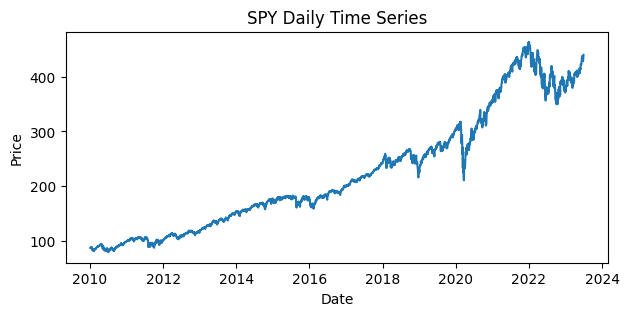

In [4]:
# Plot time series data
plt.figure(figsize=(7, 3))
plt.plot(price)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SPY Daily Time Series')
plt.show()

<h3> SPY Daily First Differenced Time Series </h3>

In [5]:
price_diff = price.diff().dropna()

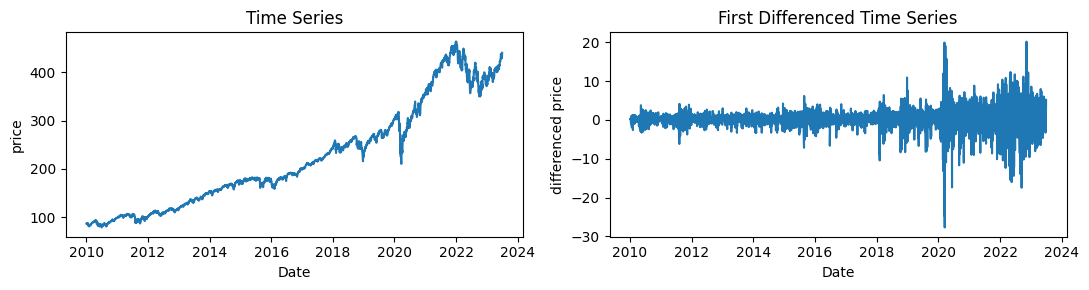

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

axes[0].plot(price)
axes[0].set_ylabel('price')
axes[0].set_xlabel('Date')
axes[0].set_title('Time Series')

axes[1].plot(price_diff)
axes[1].set_ylabel('differenced price')
axes[1].set_xlabel('Date')
axes[1].set_title('First Differenced Time Series')

plt.tight_layout()
plt.show()

<h3> Augmented Dickey-Fuller Test For Stationarity / Non-Stationarity </h3>

In [7]:
# Function to perform Augmented Dickey-Fuller Test and print the results
def perform_adf_test(series):
    result = sm.tsa.adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

<h4> ADF Test on Time Series </h4>

In [8]:
# Perform the Augmented Dickey-Fuller Test for un-differenced series
perform_adf_test(price)

ADF Statistic: 0.29791778904720345
p-value: 0.9772487538897139
Critical Values:
	1%: -3.4322930792664206
	5%: -2.8623985393870814
	10%: -2.56722701722866


<h4> ADF Test on First Differenced Time Series </h4>

In [9]:
# Perform the Augmented Dickey-Fuller Test for first-differenced series
perform_adf_test(price_diff)

ADF Statistic: -12.354519559617948
p-value: 5.726110853361603e-23
Critical Values:
	1%: -3.4322948129049493
	5%: -2.8623993051360332
	10%: -2.5672274248944094


<h3> Plot ACF & PACF </h3>

<h4> Time Series </h4>

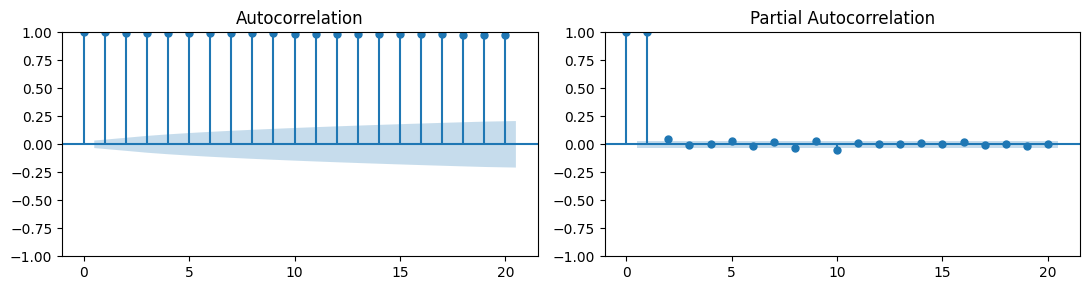

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

plot_acf(price, ax=axes[0], alpha=0.05, lags=20)
plot_pacf(price, ax=axes[1], alpha=0.05, lags=20)

plt.tight_layout()
plt.show()

<h4> First Differenced Time Series </h4>

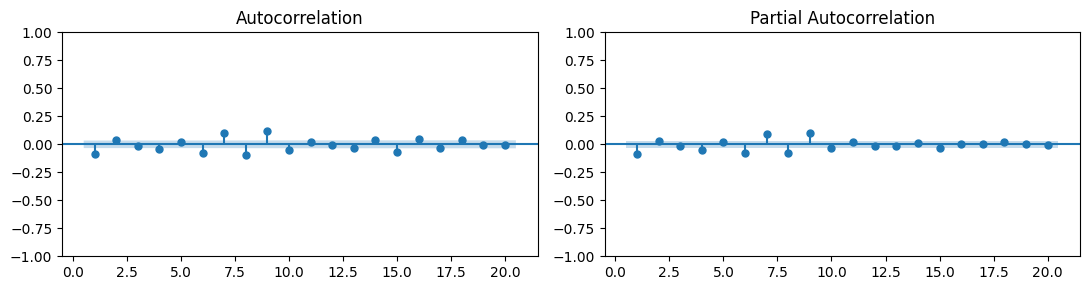

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

plot_acf(price_diff, ax=axes[0], alpha=0.05, lags=20, zero=False)
plot_pacf(price_diff, ax=axes[1], alpha=0.05, lags=20, zero=False)

plt.tight_layout()
plt.show()

<h3> Find Best ARIMA(p,d,q) Model </h3>

In [12]:
y_train, y_test = train_test_split(price, train_size=0.8)

In [13]:
# Fit the best ARIMA model
arima_model=pm.auto_arima(y_train,start_p=0,d=1,start_q=0,
          max_p=10,max_d=1,max_q=10, start_P=0,
          D=0, start_Q=0, max_P=0,max_D=0,
          max_Q=0, seasonal=False,
          error_action='warn',trace=True,
          supress_warnings=True,
          random_state=20,n_fits=50)

# Print the summary statistics of the fitted model
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11979.377, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11893.002, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11909.914, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11981.917, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11866.725, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11863.776, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11848.101, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11848.191, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11765.585, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11773.909, Time=0.57 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=11764.598, Time=0.97 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=11730.669, Time=0.91 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=11820.701, Time=0.46 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=11711.472, Time=1.09 sec
 ARIMA(7,1,0)(0,0,0

<h3> Fit ARIMA(1,1,0) Model For Comparison </h3>

In [14]:
# Fit AR(1) model
ar_model = ARIMA(y_train,order=(1,1,0)).fit()

# Print the summary statistics of the fitted model
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2716
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5946.755
Date:                Tue, 16 Jan 2024   AIC                          11897.510
Time:                        00:30:14   BIC                          11909.323
Sample:                             0   HQIC                         11901.780
                               - 2716                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1770      0.005    -33.713      0.000      -0.187      -0.167
sigma2         4.6774      0.033    142.979      0.000       4.613       4.742
Ljung-Box (L1) (Q):                   0.70   Jarque-

<h3> Model Diagnostics </h3>

<h4> ARIMA(9,1,5) Model Diagnostics </h4>

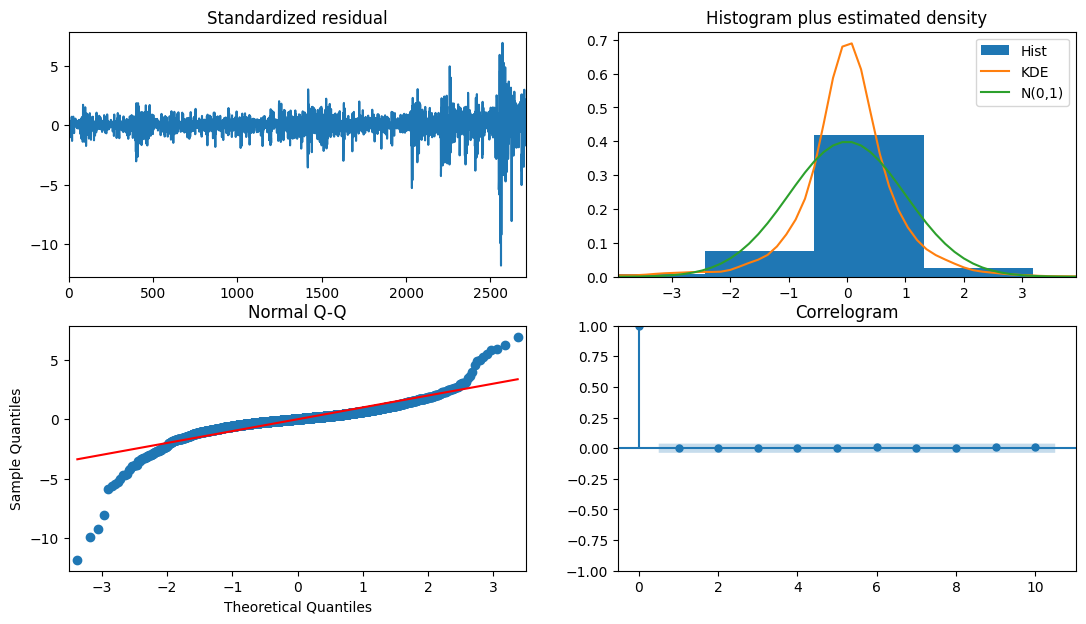

In [15]:
plt.rc("figure", figsize=(13,7))
arima_model.plot_diagnostics()
plt.show()

<h4> ARIMA(1,1,0) Model Diagnostics </h4>

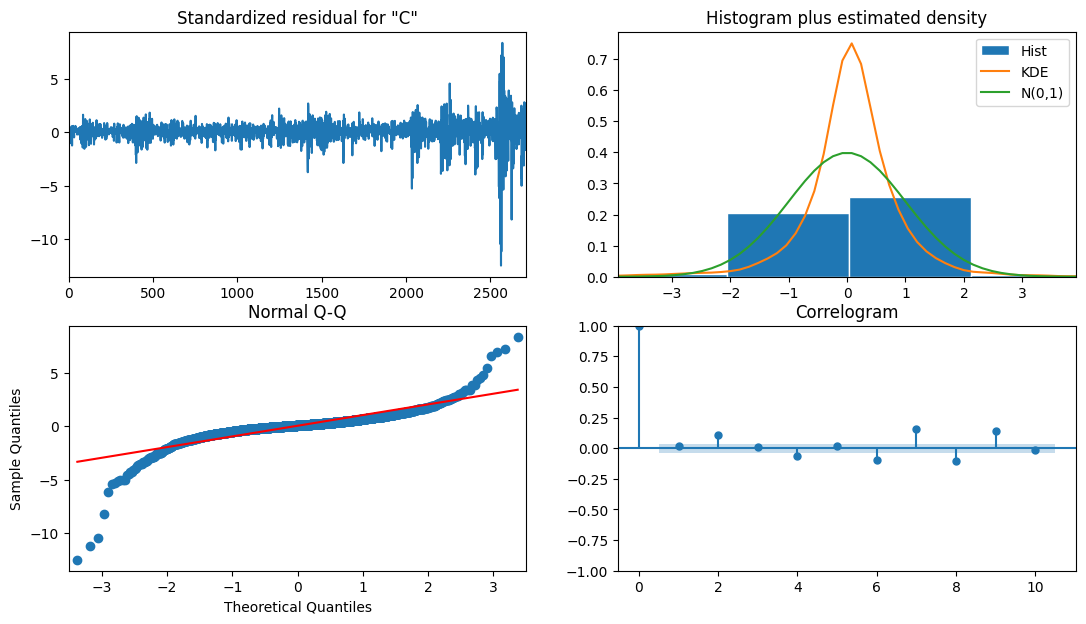

In [16]:
plt.rc("figure", figsize=(13,7))
ar_model.plot_diagnostics()
plt.show()

<h3> Forecasting </h3>

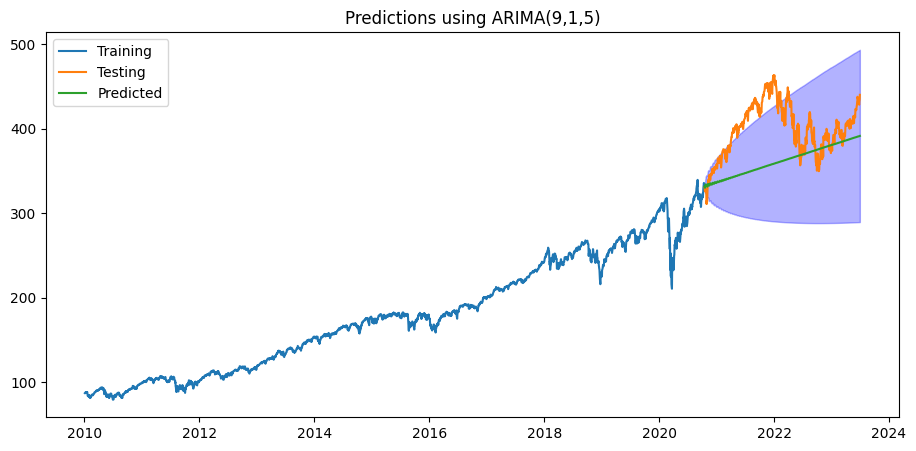

In [17]:
# prediction from ARIMA(9,1,5) model
arima_model_preds = pd.DataFrame(arima_model.predict(n_periods=y_test.shape[0]))
arima_model_preds['Date'] = y_test.index
arima_model_preds = arima_model_preds.set_index('Date')
arima_model_preds.columns = ['predictions']

# Get CI
_, ci = arima_model.predict(y_test.shape[0], return_conf_int=True)
lower = list(list(zip(*ci))[0])
upper = list(list(zip(*ci))[1])

plt.figure(figsize=(11, 5))

plt.plot(y_train,label="Training")
plt.plot(y_test,label="Testing")

plt.plot(arima_model_preds['predictions'], label="Predicted")
plt.fill_between(y_test.index,lower,upper,color='b', alpha=0.3)

plt.legend(loc = 'upper left')
plt.title('Predictions using ARIMA(9,1,5)')
plt.show()

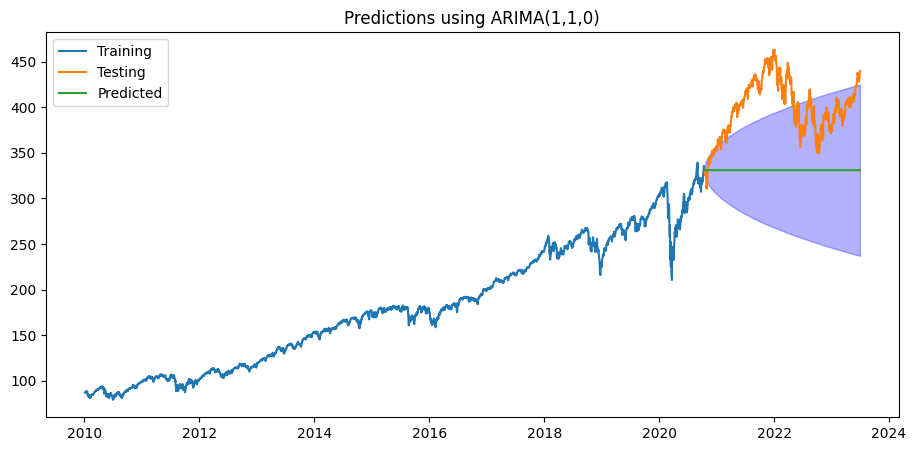

In [18]:
# prediction from ARIMA(1,1,0) model
ar_model_preds = pd.DataFrame(ar_model.forecast(y_test.shape[0]))
ar_model_preds['date'] = y_test.index
ar_model_preds = ar_model_preds.set_index('date')
ar_model_preds.columns = ['predictions']

# Get CI
ci = ar_model.get_forecast(y_test.shape[0]).conf_int()
ci['date'] = y_test.index
ci = ci.set_index('date')

plt.figure(figsize=(11, 5))

plt.plot(y_train,label="Training")
plt.plot(y_test,label="Testing")

plt.plot(ar_model_preds['predictions'], label="Predicted")
plt.fill_between(ci.index,ci.iloc[:,0],ci.iloc[:,1],color='b', alpha=0.3)

plt.legend(loc = 'upper left')
plt.title('Predictions using ARIMA(1,1,0)')
plt.show()

<h3> Performance Metrics (MAPE and MSE) </h3>

In [19]:
data = {'MAPE': [mean_absolute_percentage_error(y_test,ar_model_preds['predictions']) * 100, mean_absolute_percentage_error(y_test,arima_model_preds['predictions']) * 100],
        'MSE': [mean_squared_error(y_test,ar_model_preds['predictions']), mean_squared_error(y_test,arima_model_preds['predictions'])]}

df = pd.DataFrame(data, index = ["ARIMA(1,1,0)", "ARIMA(9,1,5)"])
df

,MAPE,MSE
"ARIMA(1,1,0)",16.719054,5621.291888
"ARIMA(9,1,5)",9.553139,2438.206044


We can conclude that ARIMA(9,1,5) Model performed better than ARIMA(1,1,0) Model.